# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [1]:
import pandas as pd

In [2]:
!ls

anime = pd.read_csv('data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

adult.csv.gz
data
Homework_1.ipynb
titanic_train.csv
week04_homework_04-01-clustering-homework.ipynb
week04_workshop_04-01-clustering-workshop.ipynb
week05_workshop_05-01-clustering-workshop.ipynb
week06_workshop_06-01-linear-regression-homework.ipynb
week2_homework_02-01-homework-numpy.ipynb
week2_homework_02-02-homework-pandas.ipynb
week2_workshop_02-01-workshop-numpy.ipynb
week2_workshop_02-02-workshop-pandas.ipynb
week3_homework_03-01-visualisation-homework.ipynb
week3_workshop_03-01-visualisation-workshop.ipynb
Workshop_1.ipynb
(12017, 6)


In [3]:
ratings = pd.read_csv('data/anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

/home/evggenshch/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


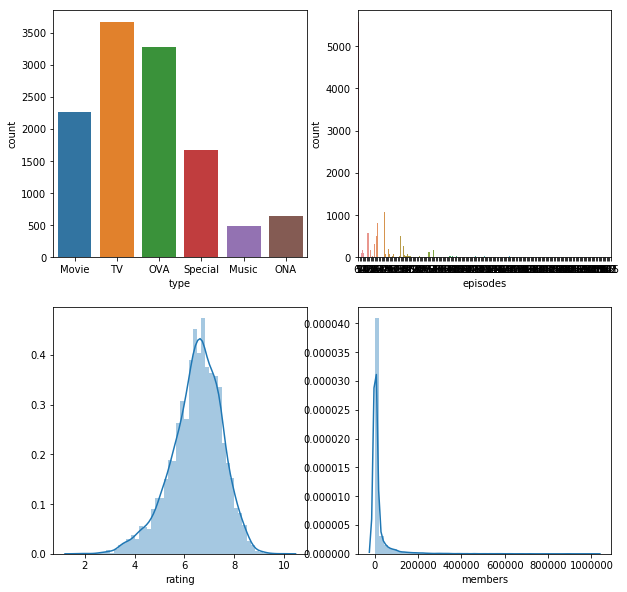

In [4]:
df1 = anime

fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
sns.countplot(df1.type, ax=ax[0][0])
sns.countplot(df1.episodes, ax=ax[0][1])
sns.distplot(df1.rating, ax=ax[1][0])
sns.distplot(df1.members, ax=ax[1][1])


## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

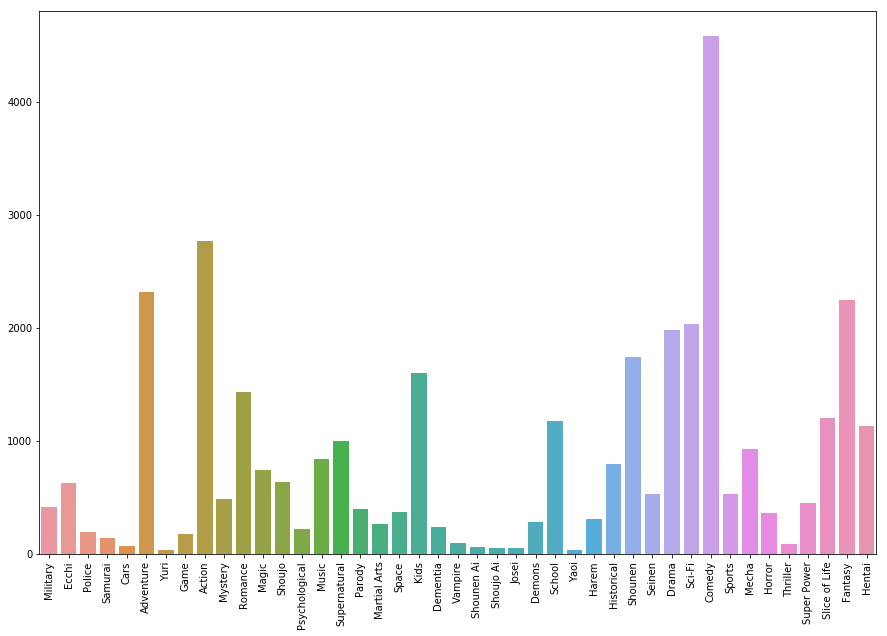

In [5]:
import numpy as np

from itertools import chain

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() 
genres = set(flatmap(genre_splitter, m_uniq))

genres = list(genres)

anime_genres = pd.DataFrame(index=anime.index)
for g in genres:
    anime_genres[g] = anime['genre'].str.contains(g).astype(int)

plt.subplots(figsize=(15,10))
genre_distr = sns.barplot(x = anime_genres.columns, y=anime_genres.sum(axis=0))
t = genre_distr.set_xticklabels(genre_distr.get_xticklabels(), rotation=90)


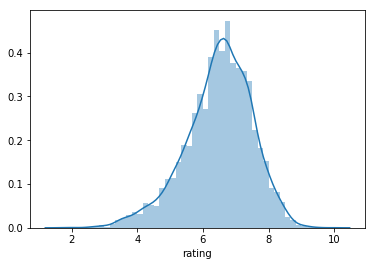

In [6]:
df2 = df1.drop(['name', 'genre', 'type', 'episodes', 'members'], axis=1)
df2

df_m = df2.join(anime_genres, on='anime_id')
sns.distplot(df_m['rating'])

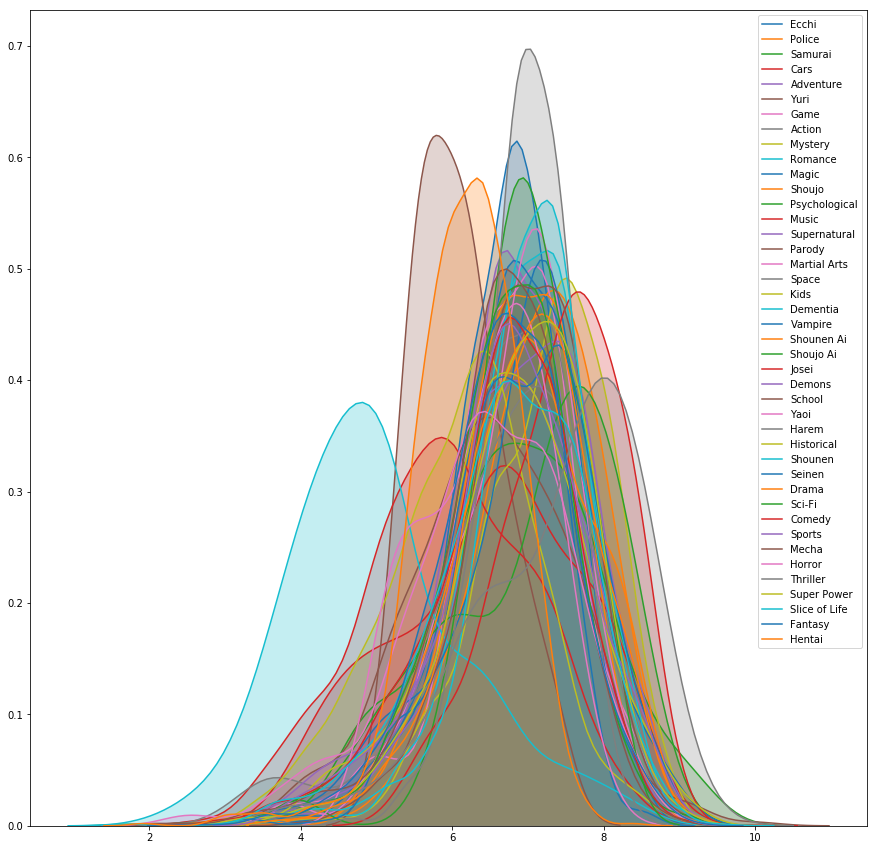

In [7]:
plt.subplots(figsize=(15,15))
with sns.color_palette("cubehelix", 44):
    for genre in df_m.columns[2:]:
        sns.kdeplot(df_m.loc[df_m[genre] == 1].rating, shade=True, label = genre)

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

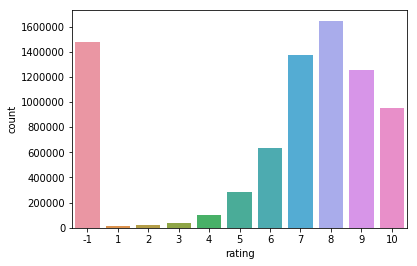

In [8]:
sns.countplot(ratings['rating'])

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [223]:
user_ratings = ratings
user_ratings = user_ratings.set_index(["user_id", "anime_id"]).count(level="user_id")
user_ratings.columns = ['num_ratings']

anime_watches = ratings
anime_watches = anime_watches.set_index(["anime_id", "user_id"]).count(level="anime_id")
anime_watches.columns = ['num_watches']

anime_ratings = anime.join(anime_watches, on='anime_id')#.drop(columns='rating')
#f = ratings.join(user_ratings, on='user_id').set_index('anime_id').drop(columns='rating')
#anime_ratings = anime_ratings.join(ratings, on='anime_id', how='outer')
#anime_ratings = ratings.join(user_ratings, on='user_id').set_index('anime_id') # .join(user_ratings, on='user_id')
#anime_ratings = anime.join(anime_watches, on='anime_id')
anime_ratings = anime_ratings.merge(ratings.join(user_ratings, on='user_id').set_index('anime_id'), on='anime_id', how='left')

In [224]:
anime_ratings = anime_ratings[(anime_ratings.num_ratings >= anime_ratings.num_ratings.median())]  
anime_ratings = anime_ratings[(anime_ratings.num_watches >= anime_ratings.num_watches.median())]
anime_ratings.loc[anime_ratings['rating_y'] == -1, 'rating_y'] = anime_ratings.loc[anime_ratings['rating_y'] == -1, 'rating_x']


In [225]:
anime_ratings.drop(columns='rating_x')
anime_ratings.rename(columns={'rating_y':'rating'}, inplace=True)

## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [226]:
anime_ratings = anime_ratings.pivot(index='user_id', columns='name', values='rating')
anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9985 entries, 5.0 to 73507.0
Columns: 653 entries, .hack//Sign to xxxHOLiC Kei
dtypes: float64(653)
memory usage: 49.8 MB


In [227]:
anime_ratings = anime_ratings.fillna(0)
#anime_ratings = anime_ratings.replace(np.nan, '', regex=True)

## Понижение размерности

kMeans будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kMeans и получите результаты).

In [309]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)

anime_ratings3 = pca.fit_transform(anime_ratings)

## Обучение kNN

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

In [310]:
import sklearn.cluster
from sklearn.cluster import KMeans

clusters_num = 10

learn_means = sklearn.cluster.KMeans(n_clusters = clusters_num)
#%time learn_means.fit(anime_ratings3)

In [311]:
index_anime = learn_means.fit_predict(anime_ratings3)
anime_ratings2 = anime_ratings
#anime_ratings2 = anime_ratings2.replace(0, np.nan)
anime_ratings2['cluster'] = index_anime

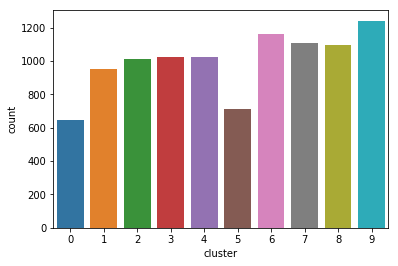

In [312]:
sns.countplot(anime_ratings2['cluster'])

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [315]:
#anime_ratings3 = anime_ratings2
#anime_ratings3.replace('0', None)
clusters = pd.DataFrame(columns=anime_ratings2.columns)
#clusters.replace(0, None)
#clusters = []

for i in range(clusters_num):
    #print(anime_ratings3.loc[anime_ratings3['cluster'] == i].mean(axis=1, skipna=True))
    clusters.loc[i] = anime_ratings2.loc[anime_ratings2['cluster'] == i].mean(skipna=True)
    #clusters = pd.concat(clusters, anime_ratings3.loc[anime_ratings3['cluster'] == i].mean(axis=1, skipna=True))

#clusters.drop(columns=['.hack//Sign', ])
    #anime_ratings2.loc['mean'] = anime_ratings2.loc[].mean()
#clusters.drop(columns='cluster')

#clusters

#anime_ratings3 = anime_ratings3.replace(0, np.nan)
#anime_ratings3.loc[anime_ratings3['cluster'] == 1]
#anime_ratings3.loc[anime_ratings3['cluster'] == 1].mean(skipna=True)

name,.hack//Sign,07-Ghost,11eyes,Aa! Megami-sama! (TV),Absolute Duo,Accel World,Acchi Kocchi (TV),Afro Samurai,Air,Air Gear,...,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetsuen no Tempest,Zoku Natsume Yuujinchou,Zombie-Loan,ef: A Tale of Melodies.,ef: A Tale of Memories.,xxxHOLiC,xxxHOLiC Kei,cluster
0,1.838272,2.732809,4.651512,3.258102,5.031358,6.948704,4.656790,1.968488,4.252160,5.134722,...,7.335293,7.021605,6.516358,3.197654,2.519259,3.476173,4.203951,3.422238,2.824043,0.0
1,2.504160,2.298382,2.448782,3.821586,0.133067,1.406702,0.590441,2.440326,4.994916,4.327553,...,5.886166,5.005042,0.731849,2.810294,2.832647,3.339706,4.815168,4.086376,3.293634,1.0
2,1.273478,1.732559,1.483192,0.715613,1.705435,4.133676,0.481324,2.690316,0.990711,3.039990,...,2.769516,2.385573,3.791759,0.853360,1.112510,0.510850,0.745731,0.976917,0.621324,2.0
3,0.475049,1.100858,3.244181,1.297125,5.400409,5.589786,2.139961,0.865517,1.334776,2.673177,...,6.482554,6.167251,4.453051,0.690760,0.674152,0.610117,1.194854,0.480819,0.228090,3.0
4,0.661348,3.265859,1.181729,0.725244,0.476934,2.053437,1.537793,0.422949,2.431406,1.633467,...,2.047393,1.763867,3.686006,4.229453,2.263301,0.771191,1.130391,2.415303,1.930645,4.0
5,2.337949,2.061320,2.320379,2.356320,0.871461,4.794494,2.604705,2.674649,4.706292,3.736320,...,4.983062,4.371910,4.644916,4.850674,2.278904,3.968876,4.953315,4.588090,3.990112,5.0
6,1.222369,0.513742,0.496944,0.779485,0.157185,2.098009,1.216266,1.613288,2.423622,0.996455,...,1.830515,1.414249,1.937004,2.202987,0.478575,1.971554,2.661528,1.687245,1.222421,6.0
7,1.038161,1.271082,3.194734,2.236069,0.981839,4.744148,2.983048,1.089170,3.175077,3.125987,...,6.232146,5.802705,3.055888,1.361948,1.165969,1.902687,2.713724,1.351533,0.962561,7.0
8,2.535032,1.115342,0.646804,2.418219,0.127050,0.603799,0.286986,2.258667,2.918466,2.502374,...,2.082950,1.542466,0.352548,1.437553,1.537534,0.696603,1.372055,2.565224,1.706502,8.0
9,0.364364,0.474501,0.882303,0.336675,2.496908,4.480709,1.936957,0.705765,1.616329,1.173060,...,3.134388,2.819485,3.692593,1.265282,0.302174,1.311417,1.967085,0.572182,0.410950,9.0


In [316]:
clusters = clusters.set_index(clusters['cluster'])
#clusters.loc[clusters.cluster == 0].sort_values(by = clusters.loc[clusters.cluster == 0].columns, axis = 1)
clusters_t = clusters.transpose()
#res = []

for i in range(clusters_num):
    print(clusters_t[i].nlargest(15).to_string())
#clusters

name
No Game No Life                                        8.905046
Angel Beats!                                           8.755123
Sword Art Online                                       8.542716
Toradora!                                              8.496065
Steins;Gate                                            8.373364
Shingeki no Kyojin                                     8.269228
Code Geass: Hangyaku no Lelouch                        8.256265
Hataraku Maou-sama!                                    8.207114
Code Geass: Hangyaku no Lelouch R2                     8.196512
Bakemonogatari                                         8.056049
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    8.032593
Boku wa Tomodachi ga Sukunai                           8.003056
Sakurasou no Pet na Kanojo                             7.922840
Kore wa Zombie Desu ka?                                7.914660
Clannad                                                7.912654
name
Code Geass: Hangyaku no Lelouc

## Top 5 жанров

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [283]:
anime2 = anime
anime2.append(anime2['anime_id'])
anime2.reindex(index='name')
#anime_ratings4 = clusters_t.merge(anime, on='name')

KeyError: 'anime_id'

In [277]:
anime2

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534


In [264]:
clusters_t

cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
name,,,,,,,,,,
.hack//Sign,1.794882,2.427169,1.020977,0.368501,1.313692,2.374443,2.673605,0.628168,0.514008,1.202837
07-Ghost,2.691834,1.101044,1.285267,0.472577,1.831562,2.031382,2.337167,3.192242,1.117873,0.501036
11eyes,4.603787,0.636806,3.182308,0.859461,1.499049,2.287193,2.356481,1.167710,3.260870,0.551305
Aa! Megami-sama! (TV),3.221450,2.334574,2.198190,0.320579,0.777404,2.307969,3.966953,0.717008,1.293100,0.788599
Absolute Duo,4.867012,0.111724,1.000977,2.501761,1.605770,0.881410,0.113391,0.464737,5.329395,0.175909
Accel World,6.944142,0.536007,4.682715,4.444504,3.941138,4.747814,1.518948,2.099610,5.635236,2.119513
Acchi Kocchi (TV),4.619157,0.293330,2.932353,1.740761,0.458583,2.596968,0.612768,1.564961,2.227363,1.251175
Afro Samurai,2.013299,2.090172,1.040787,0.740983,2.747446,2.715585,2.693637,0.453713,0.847675,1.549391
Air,4.201716,3.011543,3.247674,1.531737,0.939111,4.765755,4.931502,2.354464,1.282571,2.555300
